# 🏨 Dynamic Hotel Pricing Optimization
## 📉 03_Price Elasticity Modeling

**Goal:** Model how booking demand responds to changes in price, and estimate optimal pricing zones.


In [1]:
# 1️⃣ Load Data
import pandas as pd

df = pd.read_csv('../data/raw/hotel_bookings.csv')

# Filter to completed bookings only (exclude cancellations)
df = df[df['is_canceled'] == 0]

df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [2]:
# 2️⃣ Aggregate Price & Demand

# Group by price buckets → example simple binning
df['price_bucket'] = pd.cut(df['adr'], bins=[0, 50, 100, 150, 200, 300, 500, 1000])

# Count bookings per price bucket
demand_by_price = df.groupby('price_bucket').size().reset_index(name='bookings')

demand_by_price


C:\Users\atima\AppData\Local\Temp\ipykernel_17828\1096299440.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demand_by_price = df.groupby('price_bucket').size().reset_index(name='bookings')


,price_bucket,bookings
0,"(0, 50]",7706
1,"(50, 100]",33972
2,"(100, 150]",21520
3,"(150, 200]",7184
4,"(200, 300]",2848
5,"(300, 500]",187
6,"(500, 1000]",2


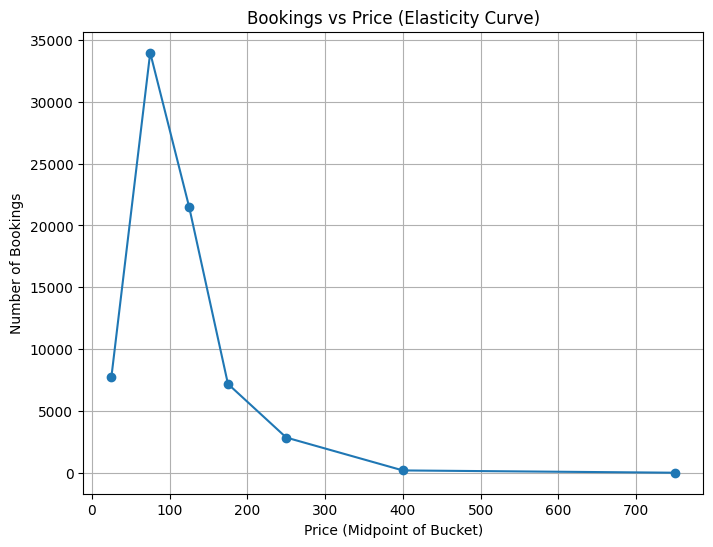

In [3]:
# 3️⃣ Plot Demand vs Price

import matplotlib.pyplot as plt

# Midpoint of each bucket → simple estimate
demand_by_price['price_mid'] = demand_by_price['price_bucket'].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))
plt.plot(demand_by_price['price_mid'], demand_by_price['bookings'], marker='o')
plt.title('Bookings vs Price (Elasticity Curve)')
plt.xlabel('Price (Midpoint of Bucket)')
plt.ylabel('Number of Bookings')
plt.grid()
plt.show()


In [4]:
# 4️⃣ Log-Log Regression (Elasticity Estimate)

import numpy as np
import statsmodels.api as sm

# Prepare log-log data
demand_by_price['price_mid'] = demand_by_price['price_mid'].astype(float)
X = np.log(demand_by_price['price_mid'])
y = np.log(demand_by_price['bookings'])

X = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

# Elasticity ≈ slope coefficient → % change in demand per % change in price


                            OLS Regression Results                            
Dep. Variable:               bookings   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     7.441
Date:                Sat, 05 Jul 2025   Prob (F-statistic):             0.0414
Time:                        20:15:04   Log-Likelihood:                -14.821
No. Observations:                   7   AIC:                             33.64
Df Residuals:                       5   BIC:                             33.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5084      4.513      4.323      0.0

c:\GitHub\DynamicHotelPricingOptimization\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


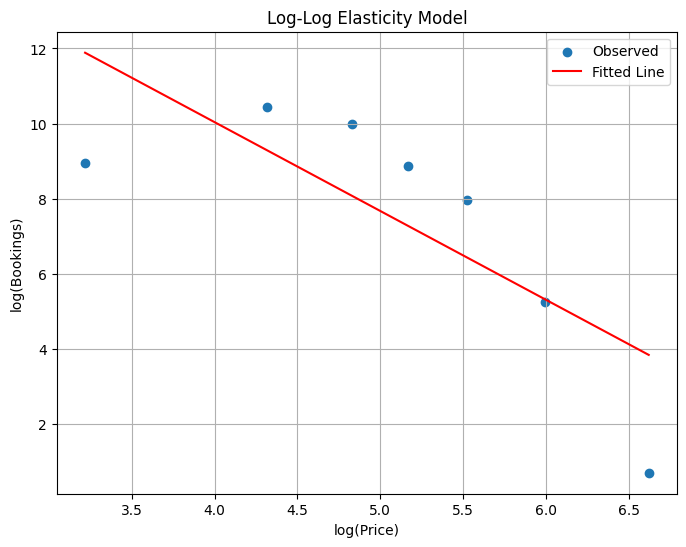

In [5]:
# 5️⃣ Visualize Fitted Elasticity Curve

y_pred = model.predict(X)

plt.figure(figsize=(8,6))
plt.scatter(np.log(demand_by_price['price_mid']), np.log(demand_by_price['bookings']), label='Observed')
plt.plot(np.log(demand_by_price['price_mid']), y_pred, color='red', label='Fitted Line')
plt.title('Log-Log Elasticity Model')
plt.xlabel('log(Price)')
plt.ylabel('log(Bookings)')
plt.legend()
plt.grid()
plt.show()
